# 1 Import Packages

In [ ]:
import xarray as xr
import numpy as np
import os

import src.config as config
import src.utils as utils

from torch.utils.data import TensorDataset, DataLoader

import sklearn.linear_model
from tqdm import tqdm

import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, DataLoader

# 2 Metadata

In [ ]:
ml_transform_path = os.path.join(config.data_pro_path,"ml_transform")

In [ ]:
lev_index = 0

In [ ]:
train_x_filename = "train_data_stack_lonlatstandardized.nc"
valid_x_filename = "valid_data_stack_lonlatstandardized.nc"

train_y_filename = "train_data_amoc_depth_1020_lat_26_samplestandardized.nc"
valid_y_filename = "valid_data_amoc_depth_1020_lat_26_samplestandardized.nc"

# 3 Load Data

In [ ]:
train_x_xr = xr.open_dataset(os.path.join(ml_transform_path, train_x_filename)).isel(lev=lev_index)
valid_x_xr = xr.open_dataset(os.path.join(ml_transform_path, valid_x_filename)).isel(lev=lev_index)

In [ ]:
train_y_xr = xr.open_dataset(os.path.join(ml_transform_path, train_y_filename))
valid_y_xr = xr.open_dataset(os.path.join(ml_transform_path, valid_y_filename))

In [ ]:
train_data_amoc_depth_1020_lat_26_samplestd  = xr.load_dataset(os.path.join(ml_transform_path,"train_data_amoc_depth_1020_lat_26_samplestd.nc" ))
train_data_amoc_depth_1020_lat_26_samplemean = xr.load_dataset(os.path.join(ml_transform_path,"train_data_amoc_depth_1020_lat_26_samplemean,nc"))

# 4 Processing

In [ ]:
train_x_xr_stack = train_x_xr.stack(sample=("realization","time"))
valid_x_xr_stack = valid_x_xr.stack(sample=("realization","time"))

In [ ]:
train_y_xr_stack = train_y_xr.stack(sample=("realization","time"))
valid_y_xr_stack = valid_y_xr.stack(sample=("realization","time"))


In [ ]:
valid_sample_coords = valid_y_xr_stack.sample
train_sample_coords = train_y_xr_stack.sample

train_x_ml_pt = torch.tensor(train_x_xr_stack["rho"].transpose("sample",...).values, dtype=torch.float32).unsqueeze(1).nan_to_num()
valid_x_ml_pt = torch.tensor(valid_x_xr_stack["rho"].transpose("sample",...).values, dtype=torch.float32).unsqueeze(1).nan_to_num()

train_y_ml_pt = torch.tensor(train_y_xr_stack["atlantic_moc"].values, dtype=torch.float32).unsqueeze(1)
valid_y_ml_pt = torch.tensor(valid_y_xr_stack["atlantic_moc"].values, dtype=torch.float32).unsqueeze(1)

# 5 Model

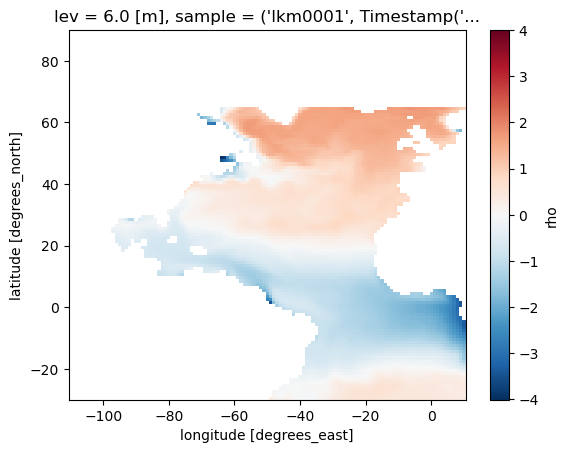

In [105]:
train_x_xr_stack.isel(sample=20)["rho"].plot.pcolormesh()

In [106]:
train_y_xr["atlantic_moc"].mean()

<xarray.DataArray 'atlantic_moc' ()>
array(1.81233945e-15)
Coordinates:
    lon      float64 ...
    lat      float64 ...
    depth_2  float64 ...

In [107]:
train_y_xr["atlantic_moc"].std()

<xarray.DataArray 'atlantic_moc' ()>
array(1.)
Coordinates:
    lon      float64 ...
    lat      float64 ...
    depth_2  float64 ...

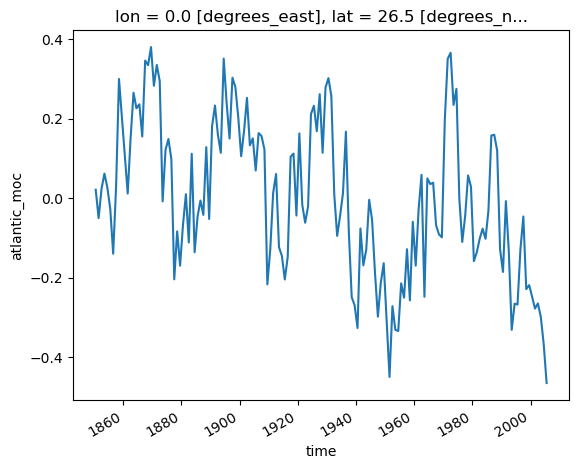

In [108]:
train_y_xr.mean(dim="realization")["atlantic_moc"].plot()

In [109]:
train_x_ml_pt.shape[0]

7800

In [110]:
train_batch_size = int(train_x_ml_pt.shape[0]/4)
valid_batch_size = valid_x_ml_pt.shape[0]

In [111]:
train_dataset = TensorDataset(train_x_ml_pt, train_y_ml_pt)  
valid_dataset = TensorDataset(valid_x_ml_pt, valid_y_ml_pt)
data_train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
data_valid_loader = DataLoader(valid_dataset, batch_size=valid_batch_size, shuffle=True)

In [157]:
120/16

7.5

In [158]:
# build the convnet from the paper
class ConvNet(torch.nn.Module):
    def __init__(self, input_channels=1, hidden_channels=5, hidden_units=5, n_outputs=1):
        super(ConvNet, self).__init__()

        self.first_conv = torch.nn.Conv2d(in_channels=input_channels, out_channels=hidden_channels, kernel_size=(10,10), padding="same")
        self.first_maxp = torch.nn.MaxPool2d(kernel_size=(4,4))
        #self.first_batch = torch.nn.BatchNorm2d(hidden_channels)
        
        self.second_conv = torch.nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=(10,10), padding="same")
        self.second_maxp = torch.nn.MaxPool2d(kernel_size=(4,4))
        #self.second_batch = torch.nn.BatchNorm2d(hidden_channels)
        
        #self.third_conv = torch.nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=(4,4), padding="same")
        self.first_fc = torch.nn.Linear(245, hidden_units)
        self.second_fc = torch.nn.Linear(hidden_units, n_outputs)

    def forward(self, x):
        x = self.first_conv(x) 
        x = torch.relu(x)
        x = self.first_maxp(x)
        #x = self.first_batch(x)
        
        x = self.second_conv(x)
        x = torch.relu(x)
        x = self.second_maxp(x)
        #x = self.second_batch(x)
        
        #x = self.third_conv(x)
        x = x.reshape(x.shape[0], -1)
        x = self.first_fc(x)
        x = torch.relu(x)
        x = self.second_fc(x)

        return x

In [159]:
x_example, y_example = iter(data_train_loader).next()

In [160]:
net = ConvNet()
res = net(x_example)

In [161]:
res.shape

torch.Size([1950, 1])

In [162]:
n_parameters = 0
for p in net.parameters():
  print(p.numel())
  n_parameters += p.numel()
n_parameters

500
5
2500
5
1225
5
5
1


4246

In [163]:
121*120

14520

In [164]:
train_x_xr

<xarray.Dataset>
Dimensions:      (realization: 50, time: 156, lon: 121, lat: 120)
Coordinates:
  * realization  (realization) object 'lkm0001' 'lkm0002' ... 'lkm0050'
  * time         (time) datetime64[ns] 1850-07-01T06:00:00 ... 2005-07-01T06:...
  * lon          (lon) float64 -110.0 -109.0 -108.0 -107.0 ... 7.0 8.0 9.0 10.0
  * lat          (lat) float64 -29.5 -28.5 -27.5 -26.5 ... 86.5 87.5 88.5 89.5
    lev          float64 6.0
Data variables:
    rho          (lat, lon, realization, time) float32 nan nan nan ... nan nan

In [171]:
net = ConvNet()

n_epochs = 1000
learning_rate = 0.001

lossfunc = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
train_loss_arr = []
valid_loss_arr = []

pbar = tqdm(range(n_epochs))

for epoch in pbar:
    net.train()
    for batch_index, batch in enumerate(data_train_loader):
        optimizer.zero_grad()
        # note that each time this loop is run through, the order of the data is randomly permuted!
        x_batch, y_batch = batch
        yhat_batch = net(x_batch)
        loss = lossfunc( yhat_batch, y_batch)
        loss.backward()
        train_loss_arr.append(loss.detach().numpy())

        optimizer.step()
    
    net.eval() 
    with torch.no_grad():
         batch = iter(data_valid_loader).next()
         x_batch, y_batch = batch
         yhat = net(x_batch)
         loss = lossfunc(yhat, y_batch)
         valid_loss_arr.append(loss.detach().numpy())
    pbar.set_postfix({'train_loss': train_loss_arr[-1], "val_loss": valid_loss_arr[-1]})

100%|██████████| 1000/1000 [1:14:37<00:00,  4.48s/it, train_loss=0.2703583, val_loss=0.4417853] 


In [189]:
weights = list(net.parameters())[0]

In [190]:
a = weights.detach().numpy()

In [191]:
net.first_maxp

MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)

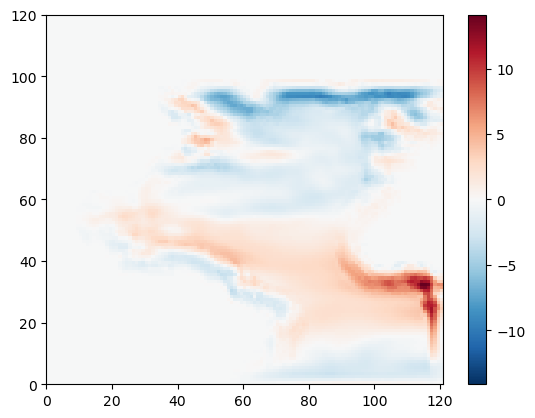

In [222]:
first_conv_res = net.first_conv(x_example).detach().numpy()

tmp = first_conv_res[0,4]

vmax= np.abs(tmp).max()
plot = plt.pcolormesh(tmp,vmin=-vmax, vmax=vmax, cmap="RdBu_r")
plt.colorbar(plot)

In [224]:
torch.save(net.state_dict(),"model_state")

In [193]:
a.shape

(5, 1, 10, 10)

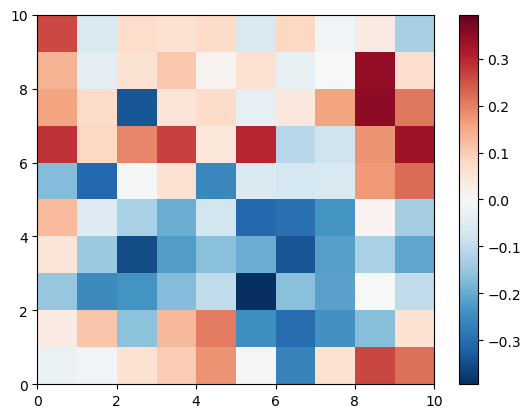

In [225]:
tmp = a[4,0]
vmax = np.abs(tmp).max()
plot = plt.pcolormesh(tmp, vmin = -vmax, vmax= vmax, cmap="RdBu_r")
plt.colorbar(plot)

(0.0, 2.0)

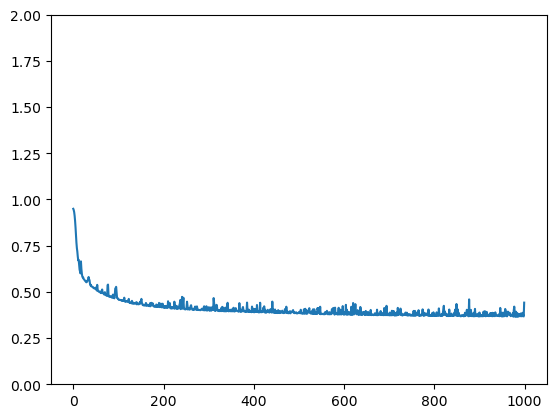

In [199]:
plt.plot(valid_loss_arr)
plt.ylim(0,2)

(0.0, 2.0)

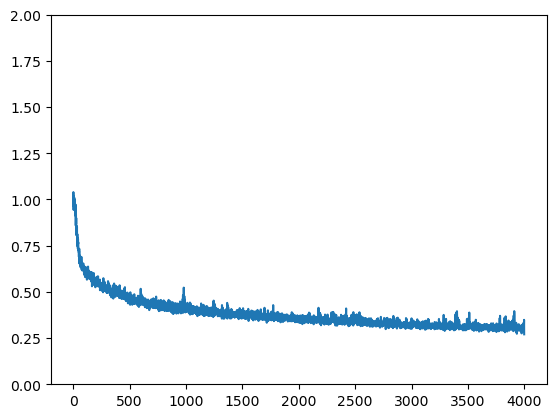

In [200]:
plt.plot(train_loss_arr)
plt.ylim(0,2)

In [201]:
valid_loss_arr[-1]

array(0.4417853, dtype=float32)

In [202]:
y_train_pred = net(train_x_ml_pt).detach().numpy()
y_train_true = train_y_ml_pt.detach().numpy()

y_valid_pred = net(valid_x_ml_pt).detach().numpy()
y_valid_true = valid_y_ml_pt.detach().numpy()

(-4.0, 4.0)

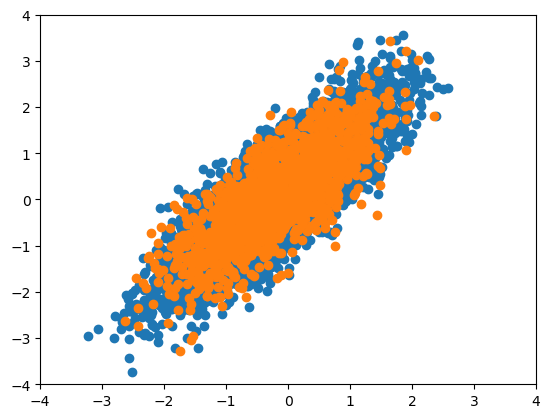

In [203]:
plt.scatter(y_train_pred, y_train_true)
plt.scatter(y_valid_pred, y_valid_true)

plt.xlim(-4,4)
plt.ylim(-4,4)